In [2]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots
)
from ripple_heterogeneity.replay import replay_run, per_cell_contribution
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
from nelpy.analysis import replay
import random
from matplotlib.ticker import AutoMinorLocator
import copy
import os
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [85]:
replay_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_82622'

replay_df = replay_run.load_results(replay_save_path,pre_task_post=False)

In [86]:
replay_df

,start,stop,duration,n_active,inactive_bin_prop,trajectory_score,r_squared,slope,intercept,score_pval_time_swap,...,traj_speed,traj_step,replay_type,pop_partic,decoding_r2,decoding_r2_pval,decoding_median_error,total_units,direction,basepath
0,23.83245,23.93245,0.10,17,0.000000,0.219740,0.934140,-30.195000,1.195600e+02,0.117882,...,1509.750000,30.195000,reverse,0.414634,0.190664,0.003984,12.152441,41.0,outbound_epochs,Z:\Data\AYAold\AB1\day1
1,24.45245,24.51245,0.06,13,0.000000,0.113963,0.274169,-16.775000,1.809667e+02,1.000000,...,838.750000,16.775000,reverse,0.317073,0.190664,0.003984,12.152441,41.0,outbound_epochs,Z:\Data\AYAold\AB1\day1
2,39.39245,39.47245,0.08,16,0.000000,0.228420,0.862687,-25.925000,3.294000e+02,0.250749,...,1296.250000,25.925000,reverse,0.390244,0.190664,0.003984,12.152441,41.0,outbound_epochs,Z:\Data\AYAold\AB1\day1
3,93.73245,93.81245,0.08,16,0.000000,0.293459,0.733945,-12.200000,2.028250e+02,0.217782,...,610.000000,12.200000,reverse,0.390244,0.190664,0.003984,12.152441,41.0,outbound_epochs,Z:\Data\AYAold\AB1\day1
4,138.13245,138.21245,0.08,18,0.000000,0.164343,0.634118,-32.635000,6.084750e+02,0.883117,...,1631.750000,32.635000,reverse,0.439024,0.190664,0.003984,12.152441,41.0,outbound_epochs,Z:\Data\AYAold\AB1\day1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161307,27399.50285,27399.56285,0.06,46,0.000000,0.004858,0.130713,45.147059,-1.576043e+06,0.657343,...,2257.352941,45.147059,forward,0.494624,0.487485,0.003984,16.453655,93.0,inbound_epochs,Z:\Data\OMLproject\OML27\day3
161308,27401.16285,27401.22285,0.06,33,0.000000,0.014273,0.706026,76.750000,-2.679653e+06,0.671329,...,3837.500000,76.750000,forward,0.354839,0.487485,0.003984,16.453655,93.0,inbound_epochs,Z:\Data\OMLproject\OML27\day3
161309,27401.50285,27401.62285,0.12,33,0.166667,0.014284,0.678671,-36.957592,1.290747e+06,0.837163,...,1847.879617,46.196990,reverse,0.354839,0.487485,0.003984,16.453655,93.0,inbound_epochs,Z:\Data\OMLproject\OML27\day3
161310,27406.02285,27406.14285,0.12,52,0.000000,0.133178,0.171754,-15.307003,5.347414e+05,0.188811,...,765.350140,15.307003,reverse,0.559140,0.487485,0.003984,16.453655,93.0,inbound_epochs,Z:\Data\OMLproject\OML27\day3


In [ ]:
# basepath = r"Z:\Data\OMLproject\OML27\day3"
# results_df = per_cell_contribution.run(
#     basepath,
#     replay_save_path=replay_save_path,
#     n_shuffles_single_cell=500,
#     n_shuffles_corr=500,
# )


In [93]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\per_cell_contribution_v1"
)
batch_analysis.run(
    replay_df,
    save_path,
    per_cell_contribution.run,
    parallel=True,
    verbose=True,
    replay_save_path=replay_save_path,
    n_shuffles_single_cell=1000,
    n_shuffles_corr=1000,
)

results_df = batch_analysis.load_results(save_path)

100%|██████████| 95/95 [21:27<00:00, 13.55s/it]


In [ ]:
sns.boxplot(data=results_df.query("environment=='sleep'"),y="pcc",x="deepSuperficial",showfliers=False)
sns.stripplot(data=results_df.query("environment=='sleep'"),y="pcc",x="deepSuperficial",color="k")


## Testing below

In [8]:
# locate saved replay file and load it
save_file = os.path.join(
    replay_save_path, basepath.replace(os.sep, "_").replace(":", "_") + ".pkl"
)

with open(save_file, "rb") as f:
    results = pickle.load(f)

In [13]:
tuningcurve = results["outbound_epochs"]["tc"]
tuningcurve

<TuningCurve1D at 0x284e3997a90> with shape (93, 103)

In [40]:
import random

tuningcurve_new = copy.deepcopy(tuningcurve)

shuff_idx = random.sample(range(tuningcurve_new.ratemap.shape[1]),tuningcurve_new.ratemap.shape[0])
x = [np.roll(tc,shuff_val) for tc, shuff_val in zip(tuningcurve_new.ratemap,shuff_idx)]
x = np.array(x)

<AxesSubplot:>

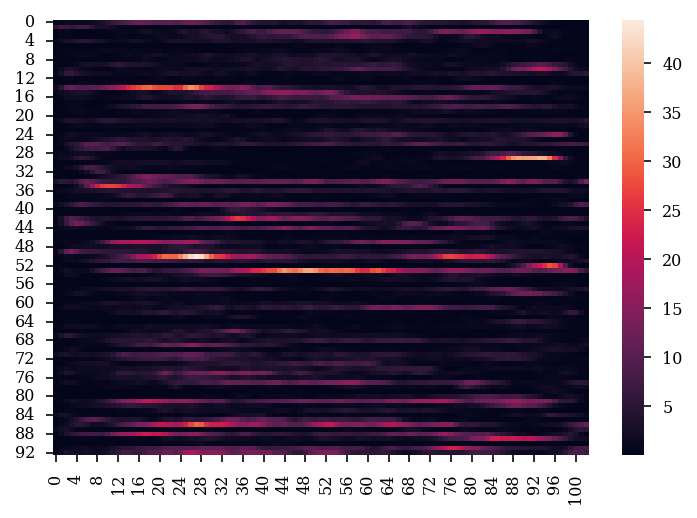

In [26]:
sns.heatmap(tuningcurve_new.ratemap)

In [49]:
n_active = [bst_.n_active for bst_ in bst]
    

In [52]:
np.array(n_active).shape

(7024,)

In [47]:
bst = results["outbound_epochs"]["bst_placecells"]
bst.n_active_per_bin.shape

(34925,)

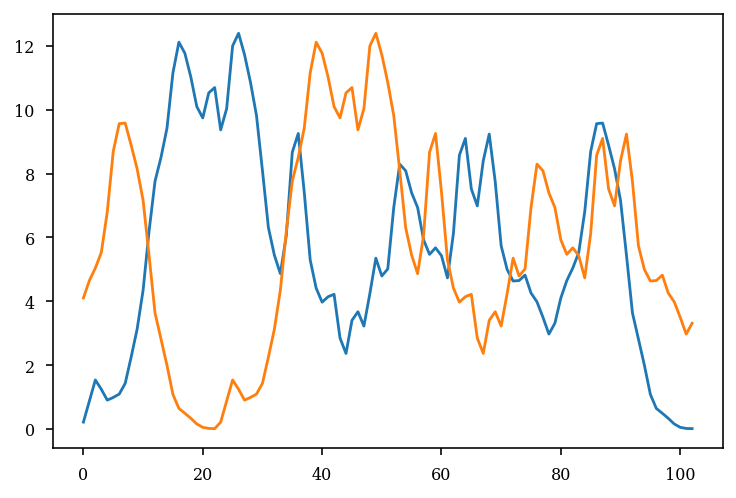

In [41]:
plt.plot(tuningcurve_new.ratemap[0,:])

plt.plot(x[0,:])

<AxesSubplot:>

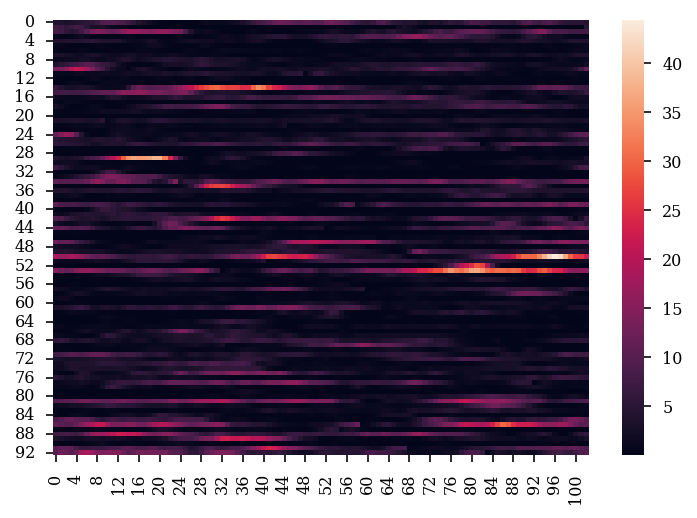

In [31]:
sns.heatmap(x)
